<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/gradient_boosting_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd

In [39]:
!git clone https://github.com/dernameistegal/airbnb_price.git

Cloning into 'airbnb_price'...
remote: Enumerating objects: 1219, done.
remote: Counting objects: 100% (1219/1219), done.
remote: Compressing objects: 100% (1152/1152), done.
remote: Total 1219 (delta 734), reused 318 (delta 58), pack-reused 0
Receiving objects: 100% (1219/1219), 10.25 MiB | 10.56 MiB/s, done.
Resolving deltas: 100% (734/734), done.



# Gradient Boosting regression

This example demonstrates Gradient Boosting to produce a predictive
model from an ensemble of weak predictive models. Gradient boosting can be used
for regression and classification problems. Here, we will train a model to
tackle a diabetes regression task. We will obtain the results from
:class:`~sklearn.ensemble.GradientBoostingRegressor` with least squares loss
and 500 regression trees of depth 4.

Note: For larger datasets (n_samples >= 10000), please refer to
:class:`~sklearn.ensemble.HistGradientBoostingRegressor`.


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
%cd airbnb_price
import sys
sys.path.append("/content/airbnb_price/custom_functions")
import general_utils as ut

/content/airbnb_price/airbnb_price


In [42]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Maria Telenczuk <https://github.com/maikia>
#         Katrina Ni <https://github.com/nilichen>
#
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime

## Load the data

First we need to load the data.



In [ ]:
desc = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/embeddings/descriptions.pickle")
rev = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/embeddings/reviews.pickle")
thumb = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/embeddings/thumbnails.pickle")
features = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/data1/listings_workfile.pickle")
logprice = features["log_price"]
selected_features = np.load("/content/drive/MyDrive/Colab/airbnb/data/feature_selection/selected_features.npy", allow_pickle=True)
features = features[selected_features]
desc = pd.DataFrame(desc)
thumb = pd.DataFrame(thumb)
rev = pd.DataFrame(rev)
logprice = pd.DataFrame(logprice)
data = pd.concat([thumb, desc, rev, features], axis=1)


In [ ]:
import torch

In [ ]:
train_ids, val_ids, test_ids = ut.train_val_test_split(data.index)  
traindf, valdf = data.loc[train_ids], data.loc[val_ids]
y_train, y_test = logprice.loc[train_ids].to_numpy().ravel(), logprice.loc[val_ids].to_numpy().ravel()

In [ ]:
# TODO
# create dataloaders
X_train = np.hstack((torch.from_numpy(np.apply_along_axis(np.concatenate, 1, np.array(traindf["thumbnails"])[:, np.newaxis])), 
                         torch.from_numpy(np.apply_along_axis(np.concatenate, 1, np.array(traindf["descriptions"])[:, np.newaxis])), 
                         torch.from_numpy(np.apply_along_axis(np.concatenate, 1, np.array(traindf["reviews"])[:, np.newaxis])),
                         torch.from_numpy(np.array(traindf.iloc[:, 3:]))))

X_test = np.hstack((torch.from_numpy(np.apply_along_axis(np.concatenate, 1, np.array(valdf["thumbnails"])[:, np.newaxis])), 
                       torch.from_numpy(np.apply_along_axis(np.concatenate, 1, np.array(valdf["descriptions"])[:, np.newaxis])), 
                       torch.from_numpy(np.apply_along_axis(np.concatenate, 1, np.array(valdf["reviews"])[:, np.newaxis])),
                       torch.from_numpy(np.array(valdf.iloc[:, 3:]))))

## Data preprocessing

Next, we will split our dataset to use 70% for training and 15% for validation. We will also set the regression model parameters. You can play
with these parameters to see how the results change.

`n_estimators` : the number of boosting stages that will be performed.
Later, we will plot deviance against boosting iterations.

`max_depth` : limits the number of nodes in the tree.
The best value depends on the interaction of the input variables.

`min_samples_split` : the minimum number of samples required to split an
internal node.

`learning_rate` : how much the contribution of each tree will shrink.

`loss` : loss function to optimize. The least squares function is  used in
this case however, there are many other options (see
:class:`~sklearn.ensemble.GradientBoostingRegressor` ).



In [ ]:
# TODO
# create dataloaders
X_train = np.array(traindf.iloc[:, 3:])

X_test = np.array(valdf.iloc[:, 3:])

In [ ]:
params = {
    "n_estimators": 5000,
    "max_depth": 10,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [ ]:
# Baseline performance
mean_prediction = np.mean(y_train)

mse = mean_squared_error(y_test, np.ones(len(y_test)) * mean_prediction)
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

The root mean squared error (MSE) on test set: 0.6490


## Fit regression model

Now we will initiate the gradient boosting regressors and fit it with our
training data. Let's also look and the mean squared error on the test data.



In [ ]:
start = datetime.now()
# result for only features
reg = ensemble.GradientBoostingRegressor(**params, verbose=1, n_iter_no_change=100)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))

end = datetime.now()
print("time to obtain model: ", (end-start).total_seconds())
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

      Iter       Train Loss   Remaining Time 
         1           0.4358            9.68m
         2           0.4296            8.03m
         3           0.4236            7.48m
         4           0.4178            7.18m
         5           0.4120            6.99m
         6           0.4063            6.95m
         7           0.4008            6.86m
         8           0.3954            6.81m
         9           0.3901            6.77m
        10           0.3848            6.80m
        20           0.3375            6.52m
        30           0.2984            6.40m
        40           0.2649            6.35m
        50           0.2370            6.30m
        60           0.2136            6.27m
        70           0.1936            6.25m
        80           0.1762            6.23m
        90           0.1613            6.20m
       100           0.1484            6.18m
       200           0.0755            6.02m
       300           0.0437            5.92m
       40

In [ ]:
start = datetime.now()
# result for features + embeddings
reg = ensemble.GradientBoostingRegressor(**params, verbose=1, n_iter_no_change=100)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))

end = datetime.now()
print("time to obtain model: ", (end-start).total_seconds())
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

      Iter       Train Loss   Remaining Time 
         1           0.4253           95.26m
         2           0.4177          138.17m
         3           0.4103          142.34m
         4           0.4030          130.19m
         5           0.3958          122.73m
         6           0.3888          117.75m
         7           0.3819          114.19m
         8           0.3752          111.56m
         9           0.3685          109.44m
        10           0.3620          107.76m
        20           0.3035          100.08m
        30           0.2553           97.37m
        40           0.2153           95.96m
        50           0.1823           95.05m
        60           0.1549           94.46m
        70           0.1320           93.86m
        80           0.1130           93.38m
        90           0.0972           92.97m
       100           0.0839           92.59m
       200           0.0256           90.18m
       300           0.0120           88.58m
       40

In [ ]:
start = datetime.now()
# result for features + embeddings

reg = ensemble.GradientBoostingRegressor(**params, verbose=1, n_iter_no_change=100, max_features=0.1)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))

end = datetime.now()
print("time to obtain model: ", (end-start).total_seconds())
print("The root mean squared error (MSE) on test set: {:.4f}".format(np.sqrt(mse)))

      Iter       Train Loss   Remaining Time 
         1           0.4279           16.06m
         2           0.4204           17.05m
         3           0.4129           17.14m
         4           0.4056           16.66m
         5           0.3985           16.45m
         6           0.3916           15.35m
         7           0.3848           14.72m
         8           0.3780           14.19m
         9           0.3714           13.79m
        10           0.3649           13.47m
        20           0.3065           11.86m
        30           0.2581           11.48m
        40           0.2182           11.27m
        50           0.1850           11.10m
        60           0.1574           10.94m
        70           0.1346           10.86m
        80           0.1157           10.79m
        90           0.0998           10.76m
       100           0.0865           10.73m
       200           0.0275           10.30m
       300           0.0136           10.14m
       40

## Plot training deviance

Finally, we will visualize the results. To do that we will first compute the
test set deviance and then plot it against boosting iterations.



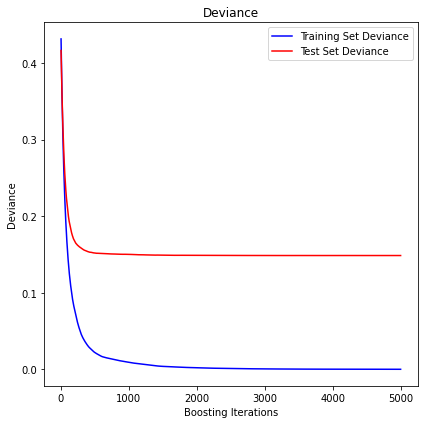

In [ ]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

## Plot feature importance

<div class="alert alert-danger"><h4>Warning</h4><p>Careful, impurity-based feature importances can be misleading for
   **high cardinality** features (many unique values). As an alternative,
   the permutation importances of ``reg`` can be computed on a
   held out test set. See `permutation_importance` for more details.</p></div>

For this example, the impurity-based and permutation methods identify the
same 2 strongly predictive features but not in the same order. The third most
predictive feature, "bp", is also the same for the 2 methods. The remaining
features are less predictive and the error bars of the permutation plot
show that they overlap with 0.



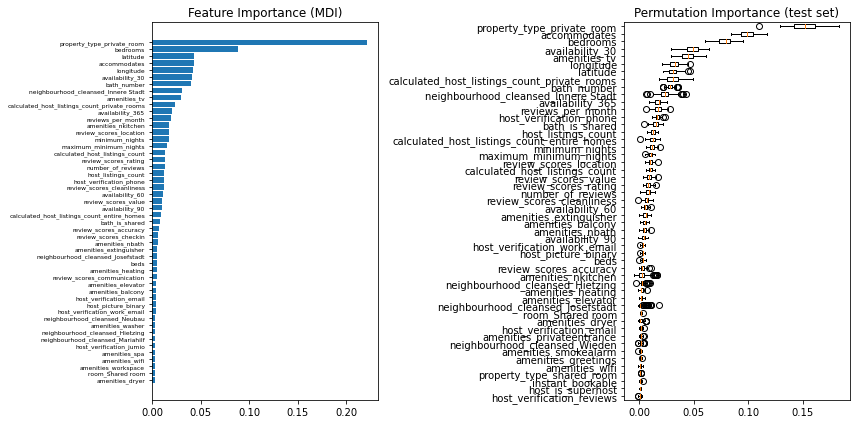

time to generate permutation importance:  4819.930598


In [ ]:
start = datetime.now()
n_features = 50

feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_idx = sorted_idx[:n_features][::-1]
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx], fontsize=6)
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=100, random_state=42, n_jobs=2
)
sorted_idx2 = result.importances_mean.argsort()[::-1]
sorted_idx2 = sorted_idx2[:n_features][::-1]
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx2].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx2],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

end = datetime.now()
print("time to generate permutation importance: ", (end-start).total_seconds())

In [ ]:
# make dataframe from feature importances
df = pd.DataFrame(result.importances, index=X.columns)

In [ ]:
# save dataframe 
path = "/content/drive/MyDrive/Colab/airbnb/data/feature_selection/permutation_importance.pickle"
df.to_pickle(path)

In [50]:
# load dataframe
df = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/feature_selection/permutation_importance.pickle")

In [51]:
df = df.drop("host_listings_count")

In [52]:
# calculate importances_mean
importances_mean = np.array(np.mean(df, axis=1))

In [53]:
# significance test
significant = np.sum(np.array(df) >= 0, axis=1) >= 95
index_significant = np.where(significant)[0]

In [54]:
# get column names, importances and mean importances that are significant
importances_mean_significant = importances_mean[index_significant]
importances_significant = np.array(df)[index_significant]
columns_significant = df.index[index_significant]

In [55]:
# argsort to select only the 70 most important features of all significant features
sorted_idx = importances_mean_significant.argsort()[::-1]
sorted_idx = sorted_idx[:70]
sorted_idx = sorted_idx[::-1]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 138 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/textpath.py:84: RuntimeWarning: Glyph 138 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 138 missing from current font.
  font.set_text(s, 0, flags=flags)


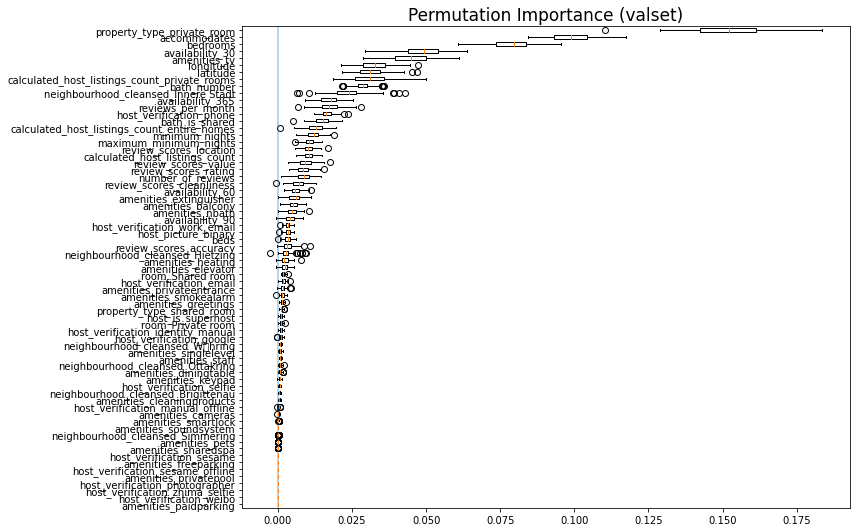

In [56]:
fig = plt.figure(figsize=(12, 7.5))
plt.yticks(fontsize=10)
plt.boxplot(
    importances_significant[sorted_idx].T,
    vert=False,
    labels=np.array(columns_significant)[sorted_idx],
)
plt.axvline(x=0, alpha=0.4)
plt.title("Permutation Importance (valset)", fontsize=17)
fig.tight_layout()
plt.savefig(str("/content/file1.svg"), bbox_inches='tight', format="svg", transparent=True)
plt.show()

In [57]:
np.save("/content/drive/MyDrive/Colab/airbnb/data/feature_selection/selected_features2.npy", np.array(columns_significant)[sorted_idx])